# Домашнее задание по теме "Функции потерь и оптимизация"

<pre>
ФИО: Никифоров Владимир
</pre>

* Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/
* Реализовать самостоятельно логистическую регрессию
    * Обучить ее методом градиентного спуска
    * Методом nesterov momentum
    * Методом rmsprop
* В качестве dataset'а взять Iris, оставив 2 класса:
    * Iris Versicolor
    * Iris Virginica

In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()

In [2]:
iris = datasets.load_iris()
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


In [3]:
# Сделаем в виде пандас-фрейма
df = pd.concat([pd.DataFrame(data=iris.data,columns=['c1','c2','c3','c4']),pd.DataFrame(data=iris.target,columns=['target'])],axis=1)
# Оставим лишь нужные нам классы Versicolor и Virginica, т.е. где target != 0
df = df[df['target']!=0]
# Для бинарной классификации превратим классы 1 и 2 в классы 0 и 1
df['target'] = df['target'] - 1
df.head()

,c1,c2,c3,c4,target
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0


In [4]:
X, Y = df.drop('target',axis=1).values, df['target'].values

In [5]:
X, Y

(array([[7. , 3.2, 4.7, 1.4],
        [6.4, 3.2, 4.5, 1.5],
        [6.9, 3.1, 4.9, 1.5],
        [5.5, 2.3, 4. , 1.3],
        [6.5, 2.8, 4.6, 1.5],
        [5.7, 2.8, 4.5, 1.3],
        [6.3, 3.3, 4.7, 1.6],
        [4.9, 2.4, 3.3, 1. ],
        [6.6, 2.9, 4.6, 1.3],
        [5.2, 2.7, 3.9, 1.4],
        [5. , 2. , 3.5, 1. ],
        [5.9, 3. , 4.2, 1.5],
        [6. , 2.2, 4. , 1. ],
        [6.1, 2.9, 4.7, 1.4],
        [5.6, 2.9, 3.6, 1.3],
        [6.7, 3.1, 4.4, 1.4],
        [5.6, 3. , 4.5, 1.5],
        [5.8, 2.7, 4.1, 1. ],
        [6.2, 2.2, 4.5, 1.5],
        [5.6, 2.5, 3.9, 1.1],
        [5.9, 3.2, 4.8, 1.8],
        [6.1, 2.8, 4. , 1.3],
        [6.3, 2.5, 4.9, 1.5],
        [6.1, 2.8, 4.7, 1.2],
        [6.4, 2.9, 4.3, 1.3],
        [6.6, 3. , 4.4, 1.4],
        [6.8, 2.8, 4.8, 1.4],
        [6.7, 3. , 5. , 1.7],
        [6. , 2.9, 4.5, 1.5],
        [5.7, 2.6, 3.5, 1. ],
        [5.5, 2.4, 3.8, 1.1],
        [5.5, 2.4, 3.7, 1. ],
        [5.8, 2.7, 3.9, 1.2],
        [6

In [6]:
EPOCHS = 1000
LEARNING_RATE = 0.01
RANDOM_STATE = 7

Наш sigmoid:

$${\displaystyle \sigma (x)={\frac {1}{1+e^{-x}}}.}$$

In [7]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def sigmoid_derivative(x):
    return np.exp(-x)/((1 + np.exp(-x))**2)

Наш loss = cost_function:

$$J = -\sum_{i=1}^{N} y_i\log (h_\theta(x_i)) + (1 - y_i)\log(1 - h_\theta(x_i))$$

In [8]:
def cost_function(Y_label, Y_pred):
    return - np.sum((Y_label * np.log(Y_pred)) + ((1. - Y_label) * np.log(1. - Y_pred)))

In [9]:
def der_theta0(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i])
    return total_cost / (len(X))

In [10]:
def der_theta1(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,0]
    return total_cost / (len(X))

In [11]:
def der_theta2(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,1]
    return total_cost / (len(X))

In [12]:
def der_theta3(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,2]
    return total_cost / (len(X))

In [13]:
def der_theta4(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,3]
    return total_cost / (len(X))

In [14]:
def train_model(X, Y, epochs=EPOCHS, lr=LEARNING_RATE):
    theta0 = 1
    theta1 = 1
    theta2 = 1
    theta3 = 1
    theta4 = 1
    for e in range(epochs):
        dt0 = der_theta0(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt1 = der_theta1(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt2 = der_theta2(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt3 = der_theta3(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt4 = der_theta4(X, Y, theta0, theta1, theta2, theta3, theta4)

        theta0 -= lr * dt0
        theta1 -= lr * dt1
        theta2 -= lr * dt2
        theta3 -= lr * dt3
        theta4 -= lr * dt4

        print("EPOCH:", e, "t0:", theta0, "t1:", theta1, "t2:", theta2, "t3:", theta3, "t4:", theta4, "cost:", cost_function(Y, sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])))
    return theta0, theta1, theta2, theta3, theta4

In [15]:
theta0, theta1, theta2, theta3, theta4 = train_model(X, Y)
theta0, theta1, theta2, theta3, theta4

EPOCH: 0 t0: 0.9950000028980888 t1: 0.9703200156146312 t2: 0.9861500071636035 t3: 0.9787000108456427 t4: 0.9933700033714434 cost: 748.6463289176013
EPOCH: 1 t0: 0.9900000067593974 t1: 0.9406400364650563 t2: 0.9723000167294161 t3: 0.9574000253512468 t4: 0.98674000788271 cost: 732.6926348901727
EPOCH: 2 t0: 0.9850000119080672 t1: 0.9109600643299078 t2: 0.9584500295134836 t3: 0.9361000447685853 t4: 0.9801100139245561 cost: 716.7389489416782
EPOCH: 3 t0: 0.9800000187787761 t1: 0.8812801016004305 t2: 0.9446000466128947 t3: 0.914800070783666 t4: 0.9734800220236819 cost: 700.7852738489302
EPOCH: 4 t0: 0.975000027954965 t1: 0.8516001514945645 t2: 0.9307500695039734 t3: 0.8935001056696106 t4: 0.9668500328907584 cost: 684.8316133317975
EPOCH: 5 t0: 0.9700000402204807 t1: 0.8219202183469811 t2: 0.9169001001752944 t3: 0.8722001524941896 t4: 0.9602200474856937 cost: 668.8779724096466
EPOCH: 6 t0: 0.9650000566294143 t1: 0.7922403080024364 t2: 0.903050141308061 t3: 0.8509002154018614 t4: 0.9535900671

(0.44654888591269765,
 -0.993322083405769,
 -0.22329490809539176,
 0.8653913941715192,
 1.3732456566170808)

In [16]:
Y_pred = sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])
Y_pred = [0 if y < 0.5 else 1 for y in Y_pred]

In [17]:
# Полученная точность модели:
accuracy_score(y_true=Y, y_pred=Y_pred)

0.95

In [18]:
# проверим обучение при разбиении на тренировочную и тестовую части
# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target',axis=1).values, df['target'].values, random_state=RANDOM_STATE, test_size=0.3)

In [19]:
def train_and_test_model(X_train, y_train, X_test, y_test, epochs=EPOCHS, lr=LEARNING_RATE):
    theta0 = 1
    theta1 = 1
    theta2 = 1
    theta3 = 1
    theta4 = 1
    scores_train = []
    scores_test = []
    for e in range(epochs):
        dt0 = der_theta0(X_train, y_train, theta0, theta1, theta2, theta3, theta4)
        dt1 = der_theta1(X_train, y_train, theta0, theta1, theta2, theta3, theta4)
        dt2 = der_theta2(X_train, y_train, theta0, theta1, theta2, theta3, theta4)
        dt3 = der_theta3(X_train, y_train, theta0, theta1, theta2, theta3, theta4)
        dt4 = der_theta4(X_train, y_train, theta0, theta1, theta2, theta3, theta4)

        theta0 -= lr * dt0
        theta1 -= lr * dt1
        theta2 -= lr * dt2
        theta3 -= lr * dt3
        theta4 -= lr * dt4
        score_train = cost_function(y_train, sigmoid(theta0 + theta1*X_train[:,0] + theta2*X_train[:,1] + theta3*X_train[:,2] + theta4*X_train[:,3]))
        score_test = cost_function(y_test, sigmoid(theta0 + theta1*X_test[:,0] + theta2*X_test[:,1] + theta3*X_test[:,2] + theta4*X_test[:,3]))
        scores_train.append(score_train)
        scores_test.append(score_test)
        #print("EPOCH:", e, "t0:", theta0, "t1:", theta1, "t2:", theta2, "t3:", theta3, "t4:", theta4, "cost_train:", score_train, "cost_test:", score_test)
    
    plt.plot(range(epochs), scores_train, c='b')
    plt.scatter(range(epochs), scores_test, c='y')
    best_point = np.argmin(scores_test)
    plt.scatter(range(epochs)[best_point], scores_test[best_point], c='g', s=100)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.title("Cost vs Epochs")
    plt.legend(['train','test'])
    return theta0, theta1, theta2, theta3, theta4

(-0.8668019522013555,
 -2.405781569836453,
 -2.418995324014585,
 3.599642816212361,
 3.2710390500443522)

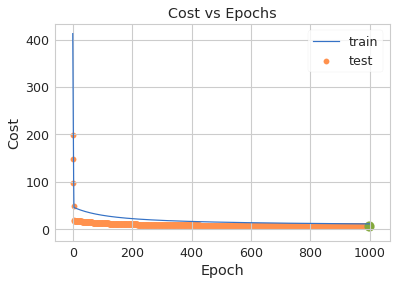

In [20]:
theta0, theta1, theta2, theta3, theta4 = train_and_test_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, lr=0.1)
theta0, theta1, theta2, theta3, theta4

In [21]:
Y_pred = sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])
Y_pred = [0 if y < 0.5 else 1 for y in Y_pred]
# Опять же сумасшедшая точность:
accuracy_score(y_true=Y, y_pred=Y_pred)

0.96

## Nesterov Accelerated Gradient

In [22]:
def linear_interpolation(X, idx):
    idx_min = floor(idx)
    idx_max = ceil(idx)
    if idx_min == idx_max or idx_max >= len(X):
        return X[idx_min]
    elif idx_min < 0:
        return X[idx_max]
    else:
        return X[idx_min] + (idx - idx_min)*X[idx_max]

In [23]:
def NM(X, gamma=0.9, lr=LEARNING_RATE):
    Y = []
    v = 0
    for i in range(len(X)):
        v = gamma*v + lr*(linear_interpolation(X, i+gamma*v) if i+gamma*v < len(X) else 0)
        Y.append(v)
    return np.asarray(Y)

In [24]:
def der_theta0_NM(X, y, theta0, theta1, theta2, theta3, theta4):
    '''total_cost = 0
    for i in range(len(X)):
        total_cost += (NM(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i])
    return total_cost / (len(X))'''
    return (NM(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y)

In [25]:
def der_theta1_NM(X, y, theta0, theta1, theta2, theta3, theta4):
    '''total_cost = 0
    for i in range(len(X)):
        total_cost += (NM(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,0]
    return total_cost / (len(X))'''
    return (NM(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y) * X[:,0]

In [26]:
def der_theta2_NM(X, y, theta0, theta1, theta2, theta3, theta4):
    '''total_cost = 0
    for i in range(len(X)):
        total_cost += (NM(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,1]
    return total_cost / (len(X))'''
    return (NM(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y) * X[:,1]

In [27]:
def der_theta3_NM(X, y, theta0, theta1, theta2, theta3, theta4):
    '''total_cost = 0
    for i in range(len(X)):
        total_cost += (NM(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,2]
    return total_cost / (len(X))'''
    return (NM(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y) * X[:,2]

In [28]:
def der_theta4_NM(X, y, theta0, theta1, theta2, theta3, theta4):
    '''total_cost = 0
    for i in range(len(X)):
        total_cost += (NM(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,3]
    return total_cost / (len(X))'''
    return (NM(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y) * X[:,3]

In [29]:
def train_model_NM(X, Y):
    theta0 = 1
    theta1 = 1
    theta2 = 1
    theta3 = 1
    theta4 = 1
    for e in range(EPOCHS):
        dt0 = der_theta0_NM(X, Y, theta0, theta1, theta2, theta3, theta4)[0]
        dt1 = der_theta1_NM(X, Y, theta0, theta1, theta2, theta3, theta4)[0]
        dt2 = der_theta2_NM(X, Y, theta0, theta1, theta2, theta3, theta4)[0]
        dt3 = der_theta3_NM(X, Y, theta0, theta1, theta2, theta3, theta4)[0]
        dt4 = der_theta4_NM(X, Y, theta0, theta1, theta2, theta3, theta4)[0]

        theta0 -= LEARNING_RATE * dt0
        theta1 -= LEARNING_RATE * dt1
        theta2 -= LEARNING_RATE * dt2
        theta3 -= LEARNING_RATE * dt3
        theta4 -= LEARNING_RATE * dt4
    
        print("EPOCH:", e, "t0:", theta0, "t1:", theta1, "t2:", theta2, "t3:", theta3, "t4:", theta4, "cost:", cost_function(Y, NM(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])))
    return theta0, theta1, theta2, theta3, theta4

In [30]:
theta0, theta1, theta2, theta3, theta4 = train_model_NM(X, Y)
theta0, theta1, theta2, theta3, theta4

/home/truename/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


EPOCH: 0 t0: 0.99827 t1: 0.98789 t2: 0.994464 t3: 0.991869 t4: 0.997578 cost: nan
EPOCH: 1 t0: 0.99655458217 t1: 0.97588207519 t2: 0.988974662944 t3: 0.983806536199 t4: 0.9951764150379999 cost: nan
EPOCH: 2 t0: 0.9948536235968891 t1: 0.9639753651782236 t2: 0.9835315955100451 t3: 0.9758120309053787 t4: 0.9927950730356446 cost: nan
EPOCH: 3 t0: 0.9931670024035909 t1: 0.9521690168251363 t2: 0.978134407691491 t3: 0.9678849112968773 t4: 0.9904338033650272 cost: nan
EPOCH: 4 t0: 0.991494597740331 t1: 0.9404621841823173 t2: 0.9727827127690594 t3: 0.9600246093795559 t4: 0.9880924368364634 cost: nan
EPOCH: 5 t0: 0.9898362897759777 t1: 0.9288540284318445 t2: 0.9674761272831289 t3: 0.9522305619470957 t4: 0.9857708056863689 cost: nan
EPOCH: 6 t0: 0.988191959689456 t1: 0.9173437178261925 t2: 0.9622142710062594 t3: 0.9445022105404436 t4: 0.9834687435652385 cost: nan
EPOCH: 7 t0: 0.9865614896612335 t1: 0.9059304276286355 t2: 0.9569967669159477 t3: 0.9368390014077982 t4: 0.9811860855257271 cost: nan
E

(0.7947994588586572,
 -0.4364037879894015,
 0.34335826834770217,
 0.0355574566356878,
 0.7127192424021189)

In [31]:
Y_pred = NM(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])
Y_pred = [0 if y < 0.5 else 1 for y in Y_pred]
# Точность случайного классификатора:)
accuracy_score(y_true=Y, y_pred=Y_pred)

0.5

## RMSProp

In [32]:
def RMSProp(X, gamma=0.9, lr=0.25, eps=0.00001):
    Y = []
    EG = 0
    for x in X:
        EG = gamma*EG + (1-gamma)*x*x
        v = lr/np.sqrt(EG + eps)*x
        Y.append(v)
    return np.asarray(Y)

In [33]:
def der_theta0_RMSProp(X, y, theta0, theta1, theta2, theta3, theta4):
    return (RMSProp(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y)

In [34]:
def der_theta1_RMSProp(X, y, theta0, theta1, theta2, theta3, theta4):
    return (RMSProp(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y) * X[:,0]

In [35]:
def der_theta2_RMSProp(X, y, theta0, theta1, theta2, theta3, theta4):
    return (RMSProp(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y) * X[:,1]

In [36]:
def der_theta3_RMSProp(X, y, theta0, theta1, theta2, theta3, theta4):
    return (RMSProp(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y) * X[:,2]

In [37]:
def der_theta4_RMSProp(X, y, theta0, theta1, theta2, theta3, theta4):
    return (RMSProp(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3]) - y) * X[:,3]

In [38]:
def train_model_RMSProp(X, Y):
    theta0 = 1
    theta1 = 1
    theta2 = 1
    theta3 = 1
    theta4 = 1
    for e in range(EPOCHS):
        dt0 = der_theta0_RMSProp(X, Y, theta0, theta1, theta2, theta3, theta4)[0]
        dt1 = der_theta1_RMSProp(X, Y, theta0, theta1, theta2, theta3, theta4)[0]
        dt2 = der_theta2_RMSProp(X, Y, theta0, theta1, theta2, theta3, theta4)[0]
        dt3 = der_theta3_RMSProp(X, Y, theta0, theta1, theta2, theta3, theta4)[0]
        dt4 = der_theta4_RMSProp(X, Y, theta0, theta1, theta2, theta3, theta4)[0]

        theta0 -= LEARNING_RATE * dt0
        theta1 -= LEARNING_RATE * dt1
        theta2 -= LEARNING_RATE * dt2
        theta3 -= LEARNING_RATE * dt3
        theta4 -= LEARNING_RATE * dt4
    
        print("EPOCH:", e, "t0:", theta0, "t1:", theta1, "t2:", theta2, "t3:", theta3, "t4:", theta4, "cost:", cost_function(Y, RMSProp(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])))
    return theta0, theta1, theta2, theta3, theta4

In [39]:
theta0, theta1, theta2, theta3, theta4 = train_model_RMSProp(X, Y)
theta0, theta1, theta2, theta3, theta4

EPOCH: 0 t0: 0.9920943071703202 t1: 0.9446601501922411 t2: 0.9747017829450245 t3: 0.9628432437005048 t4: 0.9889320300384482 cost: 85.99520614006187
EPOCH: 1 t0: 0.9841886144485822 t1: 0.8893203011400752 t2: 0.949403566235463 t3: 0.9256864879083362 t4: 0.977864060228015 cost: 85.98920532871306
EPOCH: 2 t0: 0.9762829218485806 t1: 0.8339804529400641 t2: 0.9241053499154579 t3: 0.8885297326883287 t4: 0.9667960905880127 cost: 85.98275314960378
EPOCH: 3 t0: 0.9683772293865647 t1: 0.7786406057059525 t2: 0.8988071340370068 t3: 0.8513729781168538 t4: 0.9557281211411904 cost: 85.97579747349805
EPOCH: 4 t0: 0.9604715370818097 t1: 0.7233007595726674 t2: 0.8735089186617908 t3: 0.8142162242845051 t4: 0.9446601519145335 cost: 85.96827799882261
EPOCH: 5 t0: 0.9525658449573555 t1: 0.6679609147014883 t2: 0.8482107038635375 t3: 0.7770594712995706 t4: 0.9335921829402977 cost: 85.9601246378683
EPOCH: 6 t0: 0.944660153040973 t1: 0.6126210712868103 t2: 0.8229124897311132 t3: 0.7399027192925726 t4: 0.922524214

/home/truename/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


113 t0: 0.7928048381415225 t1: -0.45036613300934286 t2: 0.3369754820528721 t3: 0.02618273926515559 t4: 0.709926773398131 cost: nan
EPOCH: 114 t0: 0.8006959615771846 t1: -0.3951282689597084 t2: 0.3622270770469907 t3: 0.06327101941276733 t4: 0.7209743462080579 cost: 87.08984374196574
EPOCH: 115 t0: 0.7927918439115716 t1: -0.45045709261899897 t2: 0.33693390051702926 t3: 0.02612166638438651 t4: 0.7099085814761997 cost: nan
EPOCH: 116 t0: 0.8006831589566609 t1: -0.3952178873033747 t2: 0.3621861086613146 t3: 0.06321084709630566 t4: 0.7209564225393246 cost: 87.0948149429742
EPOCH: 117 t0: 0.7927790481069756 t1: -0.4505466632511714 t2: 0.3368929539423219 t3: 0.026061526102785046 t4: 0.7098906673497652 cost: nan
EPOCH: 118 t0: 0.8006705481690385 t1: -0.3953061628167317 t2: 0.36214575414092287 t3: 0.06315157639448027 t4: 0.7209387674366532 cost: 87.09973017318188
EPOCH: 119 t0: 0.7927664440764537 t1: -0.45063489146482505 t2: 0.33685262104465163 t3: 0.02600228715933188 t4: 0.7098730217070345 cost

(0.7911252046958857,
 -0.4621235671287904,
 0.3316006550268396,
 0.018288462070669788,
 0.7075752865742425)

In [40]:
Y_pred = RMSProp(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])
Y_pred = [0 if y < 0.5 else 1 for y in Y_pred]
# Точность случайного классификатора:)
accuracy_score(y_true=Y, y_pred=Y_pred)

0.52